# Scattertext spaCy with Yelp Dataset
https://github.com/gyhou/yelp_dataset

https://www.yelp.com/dataset/

Exploratory data analysis and visualization for text data

In [1]:
import pandas as pd

df = pd.read_csv('yelp_reviews_RV_categories.csv')
print(df.shape)
df.head()

(5342, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,q0B39iv1bs16PO--eiMfIw,Hobo Camper Country,4020 Edmonton Trail NE,Calgary,AB,T2E 3P6,51.088523,-114.051507,1.5,NaN,"RV Repair, Auto Repair, Automotive",DLURbx1V0QyJrntcTyMR4w,1,it is todays experience that got HCC (Hobo Cam...,2016-09-06 18:06:23
1,q0B39iv1bs16PO--eiMfIw,Hobo Camper Country,4020 Edmonton Trail NE,Calgary,AB,T2E 3P6,51.088523,-114.051507,1.5,NaN,"RV Repair, Auto Repair, Automotive",0RsS3-oJ_MBJ-Fb9I-oBhA,2,"Meh, needed parts got attitude. went somewher...",2016-08-11 17:56:24
2,q0B39iv1bs16PO--eiMfIw,Hobo Camper Country,4020 Edmonton Trail NE,Calgary,AB,T2E 3P6,51.088523,-114.051507,1.5,NaN,"RV Repair, Auto Repair, Automotive",X_W-pHzDboM1jGz60f81cA,1,My father took his motorhome in to get the Ant...,2016-09-26 02:25:28
3,SW_bePWPlMZJZGQ4eT9vrA,E's RV Appliance Repair,"1959 S Power Rd, Ste 103-238",Mesa,AZ,85206,33.379981,-111.687220,5.0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Automotive, Water Heater Installation/Repair, ...",pR29E9_ird-h26CY7t18Ag,5,Eric was great! He diagnosed my LQ horse trail...,2018-05-21 15:46:27
4,SW_bePWPlMZJZGQ4eT9vrA,E's RV Appliance Repair,"1959 S Power Rd, Ste 103-238",Mesa,AZ,85206,33.379981,-111.687220,5.0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Automotive, Water Heater Installation/Repair, ...",KGZGa7Hnx6WiAVqtV_uizQ,5,Always ready to help us whenever we are in tow...,2018-04-29 23:23:56


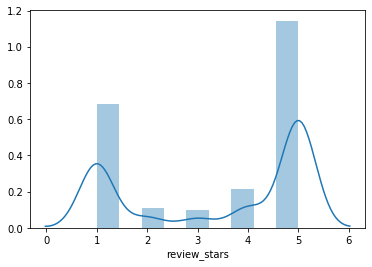

In [3]:
# Check how rating is distributed
import seaborn as sns
sns.distplot(df['review_stars']);

In [4]:
# Consolidate rating to high or low
df['rating'] = df['review_stars'].replace({1:'Low Rating', 2:'Low Rating', 3:'Low Rating',
                                           4:'High Rating', 5:'High Rating'})
df.rating.value_counts()

High Rating    3223
Low Rating     2119
Name: rating, dtype: int64

In [5]:
# Further separate RV categories
df_RV_Auto = df[df['categories'].str.contains('RV Repair|RV Dealers|RV Rental', case=False, na=False)]
df_Parks_Camp = df[df['categories'].str.contains('RV Parks|Campgrounds', case=False, na=False)]

## Use NLP on review text

In [ ]:
# Make sure you have the english language model
# small, medium, large all works
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_lg

In [6]:
import spacy
import scattertext

# use the english model that you have
nlp = spacy.load('en_core_web_lg')

In [33]:
# Create a text file to fill stop words
with open('stopwords.txt', 'r') as f:
    str_f = f.read()
    set_stopwords = set(str_f.split('\n'))
nlp.Defaults.stop_words |= set_stopwords

In [34]:
# Change dataframe for different categories
corpus_dataframe = df_RV_Auto
corpus = (scattertext.CorpusFromPandas(corpus_dataframe,
                                       category_col='rating', 
                                       text_col='text',
                                       nlp=nlp)
          .build()
          .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
         )

In [35]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['High_Rating_Score'] = corpus.get_scaled_f_scores('High Rating')
term_freq_df['Low_Rating_Score'] = corpus.get_scaled_f_scores('Low Rating')

df_high = term_freq_df.sort_values(by='High Rating freq', 
                                   ascending = False)
df_poor = term_freq_df.sort_values(by='Low Rating freq', 
                                   ascending=False)

df_high['High_Rating_Score'] = round(df_high['High_Rating_Score'], 2)
df_high['Low_Rating_Score'] = round(df_high['Low_Rating_Score'], 2)
df_high = df_high.reset_index(drop=False)

df_poor['High_Rating_Score'] = round(df_poor['High_Rating_Score'], 2)
df_poor['Low_Rating_Score'] = round(df_poor['Low_Rating_Score'], 2)
df_poor = df_poor.reset_index(drop=False)

In [36]:
# Make sure we can see all of the columns
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 200)

In [37]:
# Frequency for RV Repair, RV Dealers and RV Rental
df_high_RV_Auto = df_high
df_poor_RV_Auto = df_poor

### Score given by term association with high or low rating

In [38]:
# Sorted by High Rating Frequency for RV Repair, RV Dealers and RV Rental
df_high_RV_Auto.head(10)

,term,Low Rating freq,High Rating freq,High_Rating_Score,Poor_Rating_Score
0,service,1393,1551,0.89,0.11
1,great,193,1353,0.98,0.02
2,time,915,988,0.89,0.11
3,work,683,896,0.91,0.09
4,trailer,753,700,0.87,0.13
5,car,602,623,0.89,0.11
6,new,600,612,0.88,0.12
7,recommend,164,612,0.97,0.03
8,experience,403,572,0.92,0.08
9,good,341,519,0.92,0.08


In [39]:
# Sorted by Low Rating Frequency for RV Repair, RV Dealers and RV Rental
df_poor_RV_Auto.head(10)

,term,Low Rating freq,High Rating freq,High_Rating_Score,Poor_Rating_Score
0,service,1393,1551,0.89,0.11
1,$,1086,244,0.04,0.96
2,time,915,988,0.89,0.11
3,trailer,753,700,0.87,0.13
4,called,737,385,0.09,0.91
5,work,683,896,0.91,0.09
6,car,602,623,0.89,0.11
7,new,600,612,0.88,0.12
8,customer,518,459,0.87,0.13
9,company,484,261,0.10,0.90


In [22]:
# Frequency for RV Parks and Campgrounds
df_high_Park_Camp = df_high
df_poor_Park_Camp = df_poor

In [25]:
# Sorted by High Rating Frequency for RV Parks and Campgrounds
df_high_Park_Camp.head(10)

,term,High Rating freq,Low Rating freq,High_Rating_Score,Poor_Rating_Score
0,park,583,466,0.90,0.10
1,great,551,88,0.98,0.02
2,nice,483,196,0.95,0.05
3,clean,417,134,0.96,0.04
4,stay,322,248,0.90,0.10
5,friendly,295,83,0.97,0.03
6,pool,270,128,0.94,0.06
7,time,263,263,0.87,0.13
8,staff,251,150,0.92,0.08
9,area,249,124,0.94,0.06


In [26]:
# Sorted by Low Rating Frequency for RV Parks and Campgrounds
df_poor_Park_Camp.head(10)

,term,High Rating freq,Low Rating freq,High_Rating_Score,Poor_Rating_Score
0,park,583,466,0.90,0.10
1,time,263,263,0.87,0.13
2,room,159,260,0.10,0.90
3,service,181,256,0.12,0.88
4,stay,322,248,0.90,0.10
5,$,93,209,0.07,0.93
6,people,154,207,0.12,0.88
7,nice,483,196,0.95,0.05
8,good,231,174,0.90,0.10
9,night,122,169,0.12,0.88


In [11]:
# All 5 RV categories
df_high_RV = df_high
df_poor_RV = df_poor

In [21]:
# Sorted by High Rating Frequency for RV categories
df_high_RV.head(10)

,term,Low Rating freq,High Rating freq,High_Rating_Score,Poor_Rating_Score
0,great,263,1763,0.98,0.02
1,service,1485,1620,0.89,0.11
2,time,1100,1177,0.89,0.11
3,work,755,935,0.90,0.10
4,nice,357,746,0.94,0.06
5,trailer,805,733,0.87,0.13
6,good,481,698,0.91,0.09
7,recommend,198,694,0.97,0.03
8,new,636,678,0.89,0.11
9,car,633,660,0.88,0.12


In [20]:
# Sorted by Low Rating Frequency for RV categories
df_poor_RV.head(10)

,term,Low Rating freq,High Rating freq,High_Rating_Score,Poor_Rating_Score
0,service,1485,1620,0.89,0.11
1,$,1221,320,0.04,0.96
2,time,1100,1177,0.89,0.11
3,called,806,411,0.09,0.91
4,trailer,805,733,0.87,0.13
5,work,755,935,0.90,0.10
6,new,636,678,0.89,0.11
7,car,633,660,0.88,0.12
8,customer,569,484,0.86,0.14
9,people,554,433,0.13,0.87


## Using Scattertext to visualize term associations

In [40]:
# Label each excerpt with the name of business using the metadata parameter
html = scattertext.produce_scattertext_explorer(corpus,
                                                category='Low Rating',
                                                category_name='Low Rating',
                                                not_category_name='High Rating',
                                                width_in_pixels=1000,
                                                metadata=corpus_dataframe['name'])

In [41]:
html_file_name = "RV-Auto-Yelp-Scattertext.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

4574810